# IOGS - Neural Networks - Practical Session

## Objective

The objective of this practical session is dual:
* the creation of a simple neural network for classification
* implementation or usage of metrics and visualization tools to evaluate the performance of the training

It includes the implementation of:
* the neural network
* the optimization loop
* the test and evaluation

## Language and libraries

The whole programming part will use Python programming. 

It is a first contact with [Pytorch](https://pytorch.org/), one of the mainly used Deep Learning frameworks (along with TensorFlow).

We use it as tensor library. Note that in this session, Numpy should be sufficient to do everything.

## Imports

In [ ]:
# download and install Pytorch execute ONLY on COLAB
!pip install torch torchvision

In [1]:
import torch # Deep Learning library
import matplotlib.pyplot as plt # Result display library
from tqdm import tnrange # library for progress bars
from sklearn.metrics import classification_report # Scikit learn metrics for classification
from IPython.display import clear_output # command to clear the figures
from time import sleep

# PART 1: Neural networks

## Data generation

Two functions are given in order to generate data:
* ```generate_data(npts)``` which returns a ```npts X 2``` matrix of points with random coordinates in [-1,1]
* ```generate_bar_labels(pts)``` which returns a vector of labels with a linear separation

<font color='red'>Question 1</font>: Understand the two functions

In [2]:
def generate_data(npts):
    pts = torch.rand(npts, 2)*2-1
    return pts

def generate_bar_labels(pts):
    labels = torch.abs(pts)[:,1]>0.4
    return labels

## Visualization

In order to visualize the results (and ensure our generations functions are OK), we create a visualization function.

In [3]:
def display_pts_labels(pts, labels):
    plt.scatter(pts[labels==0][:,0], pts[labels==0][:,1])
    plt.scatter(pts[labels==1][:,0], pts[labels==1][:,1])
    plt.show()

<font color='red'>Question 2</font>: Generate 1000 points and display them.

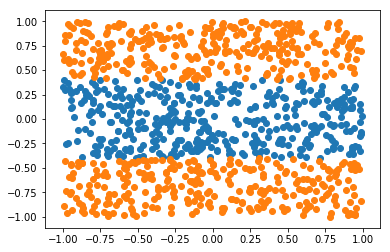

In [4]:
pts = generate_data(1000)
labels = generate_bar_labels(pts)
display_pts_labels(pts, labels)

## Evaluation

Visualisation is a good way to evaluate the performance of our algorithm, but still, we need quantitative values to assess the quality of the training.

To achieve that, we will use the functions from the Scikit Learn library. This library has already been used in the previous classes. It provides several machine learning algorithm and utility functions for evaluation. The function to be used are ```confusion_matrix``` ([here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)) and ```classification_report``` ([here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)).


### The recall

For a given class *c*, the recall measures the fraction of correctly classified samples compared to the number of samples that should have been classified *c*.

$R = \frac{Tp}{Tp+Fn}$

### The precision

For a given class *c*, the precision measures the fraction of correctly classified samples compared to the number of samples that have been predicted *c*.

$P = \frac{Tp}{Tp+Fp}$

### F1 Score

F1 score is a synthetic score, function of both recall and precision. It lies in $[0,1]$ and is 1 only if both precision and recall are 1:

$ F_1 = 2 \frac{R*P}{R+P}$

<font color='red'>Question 3</font>: in the following cell, we generated data and linear labels (the ground truth). We also generated estimated labels (the prediction). Use the documentation from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) to print the classification scores.

Grount truth


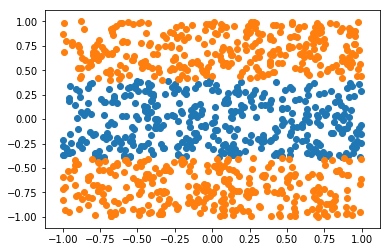

Prediction


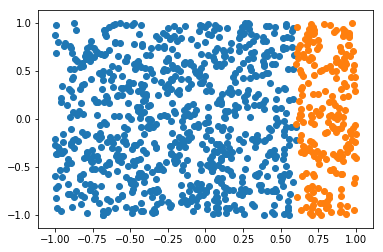

             precision    recall  f1-score   support

          0       0.38      0.78      0.51       388
          1       0.59      0.20      0.30       612

avg / total       0.51      0.43      0.38      1000



In [5]:
# generate the points and ground truth labels
print("Grount truth")
pts = generate_data(1000)
labels = generate_bar_labels(pts)
display_pts_labels(pts, labels)

# create estimated labels
print("Prediction")
estimated_labels = (pts[:,0]>0.6).long()
display_pts_labels(pts, estimated_labels)

# Display the classification scores
print(classification_report(labels, estimated_labels))

## Loss function

The loss function to be used is the cross-entropy.
For a given class label $c$, the cross entropy is defined by:

$ L(x,c) = -\log(\frac{\exp(x[c])}{\sum_i \exp(x[i])}) = -x[c] + \log(\sum_i \exp(x[i]))$

The derivative is then given by:

$ \frac{\partial{d} L}{\partial x_i} = \frac{\exp x[i])}{\sum_j \exp(x[j])}$ if $i \neq c$

and $ \frac{\partial{d} L}{\partial x_i} = \frac{\exp x[i])}{\sum_j \exp(x[j])} - 1$ if $i = c$

<font color='red'>Question 4</font>: complete the function prototypes for the loss and its derivative. Note that the output of ```cross_entropy``` is a real and the output of ```d_cross_entropy``` is a vector.

For verification purpose, the following commands:


```
print(cross_entropy(torch.FloatTensor([-2,0.8]), 1))
print(d_cross_entropy(torch.FloatTensor([-2,0.8]), 1))
```

should give these values:

```
tensor(0.0590)
tensor([ 0.0573, -0.0573])
```

In [8]:
# cross entropy function
def cross_entropy(x,target_label):
    return -x[target_label] + torch.log(torch.exp(x).sum()+1e-5)

# derivativ for cross entropy function
def d_cross_entropy(x, label):
    d_ce = torch.exp(x) /  (torch.exp(x).sum()+1e-5)
    d_ce[label] = d_ce[label] - 1
    return d_ce

# Validation of the functions
print(cross_entropy(torch.FloatTensor([-2,0.8]), 1))
print(d_cross_entropy(torch.FloatTensor([-2,0.8]), 1))

tensor(0.0590)
tensor([ 0.0573, -0.0573])


## Sigmoid function

The sigmoid is our activation function:

$\sigma(x) = \frac{1}{1+\exp{-x}}$

And its derivative:

$\frac{d \sigma(x)}{d x} = \sigma(x) * (1-\sigma(x))$

<font color='red'>Question 5</font>: complete the function prototypes for the sigmoid and its derivative. Note that the output dimension is the same as the input.

In [9]:
# sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# derivative of the sigmoid function
def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

## Network design and optimization

We have now everything that we need to build and actual neural network.
Our network will be a simple Multi Layer Perceptron with two layers of neurons separated by a sigmoid.
The loss will be a cross entropy.

The neural layer formula is given by:

$ y = W*x + b$

<font color='red'>Question 6</font>: create the $W1, b1, W2, b2$, the matrices of parameters for the layers.
Use the function ```torch.rand(dim1, dim2, ...)``` to create random tensors. ```torch.rand(dim1, dim2, ...)``` produce values in $[0,1]$, apply a transformation to the tensors to produce values in $[-1,1]$

<font color='red'>Question 7</font>: create a training set (data and labels) of size 1000.

<font color='red'>Question 8</font>: create a test set (data and labels) of size 1000.

We know iterate 10 times over the training set (10 epochs).
At each epoch the whole training set is seen by the network.

<font color='red'>Question 9</font>: compute the forward pass.

<font color='red'>Question 10</font>: compute the loss (error) using the cross entropy function.

<font color='red'>Question 11</font>: compute the derivative of the corss entropy and the paramters using the previously creatd funciton and the chain rule.

<font color='red'>Question 12</font>: update the weights with learning rate 0.01.

<font color='red'>Question 13</font>: compute the forward pass for the test set.

<font color='red'>Question 14</font>: display the testing set with the true labels and the predictions. Print the classification report.

Epoch  9
Loss tensor(0.4795)
             precision    recall  f1-score   support

          0       0.90      1.00      0.95       435
          1       1.00      0.91      0.95       565

avg / total       0.95      0.95      0.95      1000



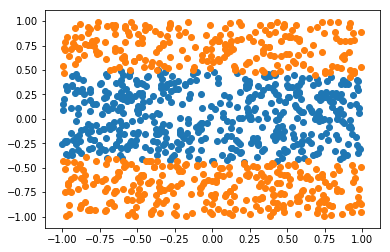

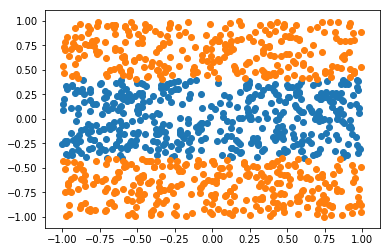

In [22]:
# Question 6: create the paramter tensors
W1 = torch.rand(2, 64)*2-1
b1 = torch.rand(64)*2-1
W2 = torch.rand(64, 2)*2-1
b2 = torch.rand(2)*2-1

# Question 7: Training set
pts = generate_data(1000)
labels = generate_bar_labels(pts)

# Question 8: Testing set
pts_test = generate_data(1000)
labels_test = generate_bar_labels(pts_test)

# learning rate
lr = 1e-2

for epoch in range(10):
    
    total_loss = 0
    for i in tnrange(pts.size(0)):

        # Question 9: forward pass
        y1 = torch.matmul(pts[i], W1) + b1
        y1_s = sigmoid(y1)
        y2 = torch.matmul(y1_s, W2) + b2
        
        # Question 10: loss
        error = cross_entropy(y2, labels[i].item())
        
        
        # Question 11: derivative
        
        # error
        dy2 = d_cross_entropy(y2, labels[i].item())
        
        # layer 2
        dW2 = torch.matmul(y1_s.unsqueeze(1), dy2.unsqueeze(0))
        db2 = dy2
        dy1_s = torch.matmul(W2, dy2)
        
        # sigmoid
        dy1 = dy1_s * d_sigmoid(y1)

        # layer 1
        dW1 = torch.matmul(pts[i].unsqueeze(1), dy1.unsqueeze(0))
        db1 = dy1

        
        # Question 12: Update the weights
        W2 = W2 - dW2 * lr
        b2 = b2 - db2 * lr
        W1 = W1 - dW1 * lr
        b1 = b1 - db1 * lr        
        
        total_loss += error
        
    
    labels_prediction = torch.zeros(pts_test.size(0))
    for i in range(pts_test.size(0)):

        # Question 13: forward pass for test data
        y1 = torch.matmul(pts_test[i], W1) + b1
        y1_s = sigmoid(y1)
        y2 = torch.matmul(y1_s, W2) + b2
        
        
        if y2[0] < y2[1]:
            labels_prediction[i] = 1

            
    clear_output() # remove all display output
    print("Epoch ", epoch)
    print("Loss", total_loss/(pts.size(0)))
    
    # Question 14: display the results
    print(classification_report(labels_test, labels_prediction))
    display_pts_labels(pts_test, labels_prediction)
    display_pts_labels(pts_test, labels_test)
    
    sleep(2) # sleep for 2 seconds (only to have time to visualize the results)
    

# PART 2: Using Pytorch functions

In the previous part, we did not used any function specific to PyTorch. We used it as a tensor library similar to NumPy.

We now go a step forward in the use of the library.
We will see how to create a network with predefined layer and use the automatic differenciation to avoid computing the gradient by hand.

First we will work on a more difficult example than before.

<font color='red'>Question 15</font>: Create more difficult classification task. Here we want create donut (label 1 for x in [-0.4, 0.4], a disk centered around 0, ...). Display a generated set for verification.

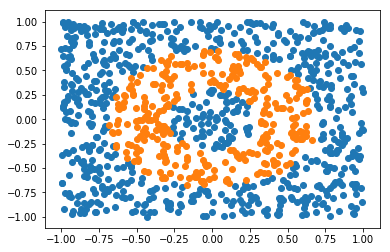

In [23]:
# Question 15
def generate_donut_labels(pts):
    labels = (pts**2).sum(dim=1)<0.49
    labels[(pts**2).sum(dim=1)<0.09] = 0
    return labels

pts = generate_data(1000)
labels = generate_donut_labels(pts)
display_pts_labels(pts, labels)

### Network definition

The networks are Python Classes that inherit from the ```torch.nn.Module``` class.
It is usually composed of two functions: ```__init__``` (the initializer) and ```forward``` that define the forward pass.

Here is an example of network with a single neural layer without non-linerarity.
The input size is 2 and the output is 16.

```
class NetworkExample(torch.nn.Module):
    def __init__(self):
        super(NetworkExample, self).__init__()
        self.l1 = torch.nn.Linear(2,16)

    def forward(self, x):
        y = self.l1(x)
        return y
```

<font color='red'>Question 16</font>: Create a network class with 3 layers separated with ReLUs.
Use the function ```torch.nn.functional.relu```. The hidden size will be 16.

In [27]:
class Network(torch.nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.l1 = torch.nn.Linear(2,16)
        self.l2 = torch.nn.Linear(16,16)
        self.l3 = torch.nn.Linear(16,2)

    def forward(self, x):
        y1 = self.l1(x)
        y1r = torch.nn.functional.relu(y1)
        y2 = self.l2(y1r)
        y2r = torch.nn.functional.relu(y2)
        y3 = self.l3(y2r)
        return y3

<font color='red'>Question 17</font>: Create training set (size 5000) and testing set (size 1000).

The next step is to create the network, this is simply done by creating an instance of the class previously defined.

Then, we create an **optimizer**, it is convenience class that contains the update policy for the weights of the network.
Here, we use **Stochastic Gradient Descent**, the optimizer class ```torch.optim.SGD```.
The first argument is the parameters of the networks (accessible by ```net.parameters()```), the second is the learning rate. There is an optional argument, the momentum, default value is 0.

The operation is then similar to the previous code.
We train for 10 epochs.
Main differences from before:

* pytorch use mini batches (several points are evaluated at the same time), so the input have a size of $(N \times D)$ where $N$ is the number of points and $D$ the dimension (2 in our case). We stick to train with one point, but we still need to resize the input to $(1,2)$. For that use the method ```x.unsqueeze(0)``` which add a dimension at position 0.

* the loss function is ```torch.nn.functional.cross_entropy(prediction, target)```

* before computiong the gradients, gradient storage must be put to zero with ```optimizer.zero_grad()```.

* the gradients are computed by using the ```backward()``` method on the loss tensor.

* the weight update is done with ```optimizer.step()```.

Epoch  9
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       674
          1       0.85      0.85      0.85       326

avg / total       0.90      0.90      0.90      1000



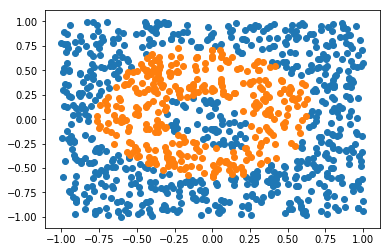

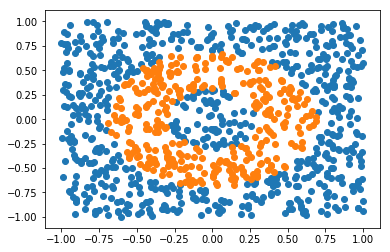

In [34]:
# Question 17: Training and testing set
pts = generate_data(5000)
labels = generate_donut_labels(pts)
pts_test = generate_data(1000)
labels_test = generate_donut_labels(pts_test)

# network creation
net = Network()

# optimizer creation
lr = 1e-2
optimizer = torch.optim.SGD(net.parameters(), lr)


for epoch in range(10):
    net.train()
    t = tnrange(pts.size(0))
    total_loss = 0
    for i in t:
        

        # create the input / target tensors
        x = pts[i].unsqueeze(0)
        target = labels[i].unsqueeze(0).long()
        
        # forward and error
        y2 = net(x)
        error = torch.nn.functional.cross_entropy(y2, target)
        
        
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        
        total_loss += error.item()
        t.set_postfix(Loss=total_loss/(i+1))

    # predict all test at one time
    net.eval()
    with torch.no_grad():
        labels_prediction = net(pts_test)
        labels_prediction = torch.argmax(labels_prediction, dim=1)

    clear_output()
    print("Epoch ", epoch)
    # display results
    print(classification_report(labels_test, labels_prediction))
    display_pts_labels(pts_test, labels_prediction)
    display_pts_labels(pts_test, labels_test)
    sleep(3)


<font color='red'>Question 18</font>: add momentum to the optimizer.